<a href="https://colab.research.google.com/github/AndresMontesDeOca/TimeSeries/blob/main/PyCaret_Diario_DIFF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyCaret (usando datos por Dia)

## Instalacion y Carga de Librerias

In [15]:
# Agregamos Prophet a PyCaret, hay que reiniciar el Kernell despues
!pip install prophet
!pip install --pre pycaret
!pip install pingouin


import numpy as np
import pandas as pd
import warnings
from pycaret.time_series import TSForecastingExperiment
from matplotlib import pyplot as plt

# Configuracion para graficas
fig_kwargs = {
#     "renderer": "notebook",
    "renderer": "png",
    "width": 1000,
    "height": 600,
}

# warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore')

# Vamos a suprimir la notacion cientifica
pd.set_option("display.float_format", lambda x:"%.2f" %x)

## Carga de los Datos por Dia


### Desde Local

In [16]:
# # Cargamos Demanda por Dia desde local
# data = pd.read_csv('Data\data_DTV.csv')
# data['Fecha'] = pd.to_datetime(data['Fecha'])
# data.set_index('Fecha', inplace=True)

# print(data.info())

### Desde Google Drive

In [17]:
# Code to read csv file into Colaboratory:
# !pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

################################# Datasets ###################################
# Demanda, Viento, Temperatura ya procesados y unidos en un solo DataFrame
id = "1Lk9Ib0cVa7vtsLXYjycjktIIhBzS3zdX"
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('data_DTV.csv')
data = pd.read_csv("data_DTV.csv", parse_dates=['Fecha'], index_col='Fecha')

# Probamos diferenciando las Series
data = data.diff(1).dropna()

print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2020-01-02 to 2022-12-31
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Demanda      1095 non-null   float64
 1   Temperatura  1095 non-null   float64
 2   Viento       1095 non-null   float64
dtypes: float64(3)
memory usage: 34.2 KB
None


* Como hicimos en el TP#1, promediamos los datos horararios del dia para reducir los datos a procesar
* En lugar de tener 26000 observaciones nos quedamos solo con 1100, esto hace mucho mas rapido correr todas las etapas del proceso de AutoML

## EDA Experiment
Diferenciamos las Series y chequeamos las relaciones de las variables exogenas Temperatura y Viento

,Description,Value
0,session_id,1515
1,Target,Demanda
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(1095, 3)"
5,Transformed data shape,"(1095, 3)"
6,Transformed train set shape,"(1064, 3)"
7,Transformed test set shape,"(31, 3)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


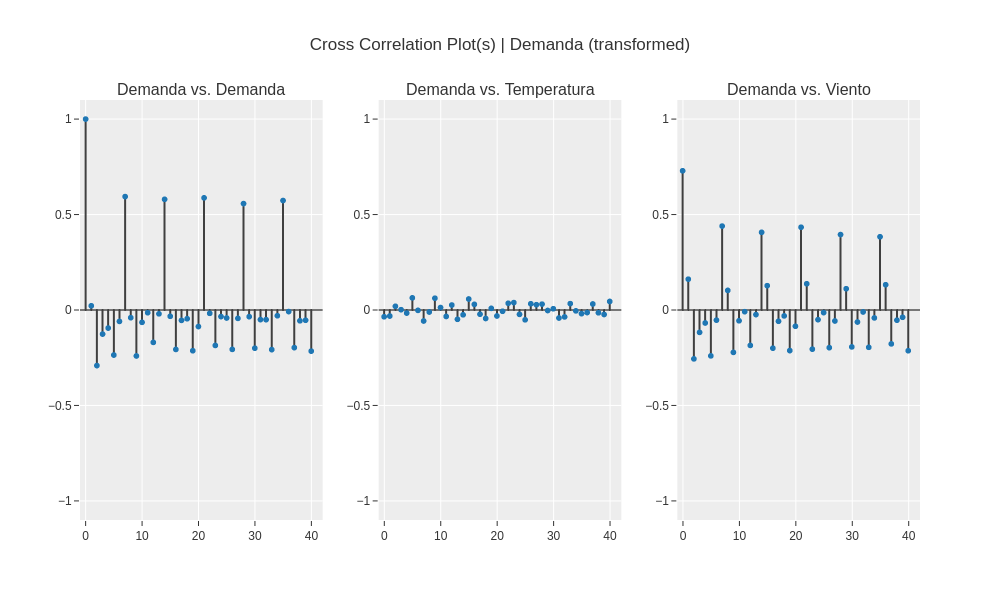

In [18]:
# Create an EDA experiment ----
eda = TSForecastingExperiment()

# Con indice implicito. Tambien probar con indice explicito luego!!!!
eda.setup(
    data=data,
    target='Demanda',
#     index=data.index,
    fh=31,
    # Set defaults for the plots ----
    fig_kwargs=fig_kwargs,
    session_id=1515,
)

# Vemos
eda.plot_model(plot="ccf", fig_kwargs=fig_kwargs)

* Se puede apreciar como las correlaciones de los distintos lags entre Demanda y Temperatura no son significantes, por ende decidimos eliminar la variable Temperatura del modelado

## AutoML

### Model Experiment

In [19]:
# Instanciamos el Experimento y configuramos la Pipeline
exp = TSForecastingExperiment()

# enforce_exogenous=False --> Use multivariate forecasting when model supports it, else use univariate forecasting
exp.setup(
    data=data.drop(columns='Temperatura'), target='Demanda', fh=31, enforce_exogenous=False,
    fig_kwargs=fig_kwargs, session_id=1515
)

,Description,Value
0,session_id,1515
1,Target,Demanda
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(1095, 2)"
5,Transformed data shape,"(1095, 2)"
6,Transformed train set shape,"(1064, 2)"
7,Transformed test set shape,"(31, 2)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


* Instanciamos el experimento, reservando para test los ultimos 31 registros (Diciembre 2022)
* Vemos como en la linea #24 ya se detecta la Estacionalidad Semanal

### Comparacion de Modelos

In [20]:
# Seteo con cuantos modelos me quiero quedar
n = 3
best_baseline_models = exp.compare_models(n_select=n, turbo=False,exclude=['tbats', 'bats', 'arima'])

# Guardamos la grilla de metricas
compare_metrics = exp.pull()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
prophet,Prophet,0.4143,0.3893,606.4619,776.9565,0.8939,0.7749,0.7975,0.4233
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.4951,0.4750,725.2636,948.2723,1.2313,1.0216,0.6969,0.7200
ets,ETS,0.4975,0.4708,728.8630,940.1422,1.3721,0.9496,0.7037,0.1333
exp_smooth,Exponential Smoothing,0.5150,0.4849,754.8538,968.3932,1.7644,0.9243,0.6842,1.2600
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.5153,0.4857,755.1349,969.8349,1.2805,1.0267,0.6833,0.9400
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.5162,0.4701,756.1081,938.4839,1.3995,0.9634,0.7040,1.2400
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,0.5299,0.4854,776.2557,969.1487,1.3681,0.9905,0.6869,1.4933
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,0.5346,0.4893,783.3585,977.0950,1.5414,1.0066,0.6800,1.7433
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.5488,0.4951,803.6398,988.2805,1.5542,0.8911,0.6737,0.9333
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,0.5511,0.5011,807.0931,1000.3279,1.5505,0.9317,0.6643,1.1467


Processing:   0%|          | 0/119 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbnva8de2/4vr49w4r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbnva8de2/59d9ew57.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32169', 'data', 'file=/tmp/tmpbnva8de2/4vr49w4r.json', 'init=/tmp/tmpbnva8de2/59d9ew57.json', 'output', 'file=/tmp/tmpbnva8de2/prophet_modelgfevyzbk/prophet_model-20231206054319.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


* Vemos que el modelo Prohet arroja mejores resultados en todas las metricas.
* Igualmente nos quedamos con los 3 mejores modelos para Ensamblarlos luego (Prophet, Matching Pursuit y Error-Trend-Seasonality)

### Tuneo de Hyper-Parametros

In [21]:
# # Tuneamos los Hyperparametros de los mejores modelos

# Si solo nos quedamos con el mejor
if n==1:
    best_tuned_models = exp.tune_model(best_baseline_models)
# Si nos quedamos con mas de uno, para hacer un blend
else:
    best_tuned_models = [exp.tune_model(model) for model in best_baseline_models]

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2022-08-29,0.3986,0.3897,588.4267,783.1874,0.9097,0.6846,0.8215
1,2022-09-29,0.3341,0.3121,491.2301,625.1968,0.7515,0.7068,0.8644
2,2022-10-30,0.4979,0.4611,721.5803,912.5001,0.9587,0.9036,0.7123
Mean,NaT,0.4102,0.3876,600.4124,773.6281,0.8733,0.7650,0.7994
SD,NaT,0.0674,0.0609,94.4212,117.4857,0.0884,0.0984,0.0640


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   13.6s finished
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbnva8de2/fz3ybbyb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbnva8de2/75e2d0e9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73315', 'data', 'file=/tmp/tmpbnva8de2/fz3ybbyb.json', 'init=/tmp/tmpbnva8de2/75e2d0e9.json', 'output', 'file=/tmp/tmpbnva8de2/prophet_modelwjfhqa18/prophet_model-20231206054336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbnva8de2/hegtwkvh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbnva8de2/dtniuxlu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65198', 'data', 'file=/tmp/tmpbnva8de2/hegtwkvh.json', 'init=/tmp/tmpbnva8de2/dtniuxlu.json', 'output', 'file=/tmp/tmpbnva8de2/prophet_modely9j4hl_q/prophet_model-20231206054337.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2022-08-29,0.5803,0.5482,856.7001,1101.6015,1.9217,1.1568,0.6468
1,2022-09-29,0.3597,0.3302,528.8273,661.6078,0.6961,0.8354,0.8481
2,2022-10-30,0.5458,0.5464,791.0016,1081.3676,1.0980,1.0706,0.5960
Mean,NaT,0.4953,0.4749,725.5097,948.1923,1.2386,1.0209,0.6970
SD,NaT,0.0969,0.1023,141.6381,202.8141,0.5101,0.1358,0.1089


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   22.3s finished


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2022-08-29,0.5944,0.5501,877.5106,1105.4056,2.1835,1.0641,0.6444
1,2022-09-29,0.3612,0.3296,531.1623,660.4159,0.7370,0.8252,0.8487
2,2022-10-30,0.5312,0.5266,769.8701,1042.1710,1.1308,0.9850,0.6247
Mean,NaT,0.4956,0.4688,726.1810,935.9975,1.3504,0.9581,0.7059
SD,NaT,0.0985,0.0988,144.7316,196.5682,0.6106,0.0994,0.1013


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.6s finished


* Tambien tiene una opcion para Auto Tunear los valores de los Hyperparametros, parecido a lo que vimos como GridSearch

### Ponderacion de Modelos y Blending

In [22]:
# Aplicamos diferente peso a cada modelo
top_model_metrics = compare_metrics.iloc[0:n]['MAE']
display(top_model_metrics)

# Si es un solo modelo, el peso es 1
if n==1:
    top_model_weights = pd.Series(1, name='MAE')
# Si son varios modelos, se calcula el peso de cada uno
else:
    top_model_weights = 1 - top_model_metrics/top_model_metrics.sum()
display(top_model_weights)

prophet      606.46
omp_cds_dt   725.26
ets          728.86
Name: MAE, dtype: object

prophet      0.71
omp_cds_dt   0.65
ets          0.65
Name: MAE, dtype: object

* Ponderamos a cada modelo segun su efectivdad, y elegimos el Mean Absolute Error como Metrica

In [23]:
# Combinamos los modelos con sus respectivos pesos
if n==1:
    blender = best_tuned_models
else:
    blender = exp.blend_models(best_tuned_models, method='mean', weights=top_model_weights.values.tolist())

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2022-08-29,0.5032,0.4762,742.8887,956.8877,1.5938,0.9760,0.7335
1,2022-09-29,0.3275,0.2906,481.4924,582.1120,0.6360,0.7777,0.8824
2,2022-10-30,0.4796,0.4746,695.1430,939.1932,0.9653,0.9393,0.6952
Mean,NaT,0.4368,0.4138,639.8414,826.0643,1.0650,0.8977,0.7704
SD,NaT,0.0779,0.0871,113.6536,172.6515,0.3973,0.0861,0.0808


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

* Vemos que tambien es sencillo hacer el Blend, y agregarle distintos pesos a cada modelo

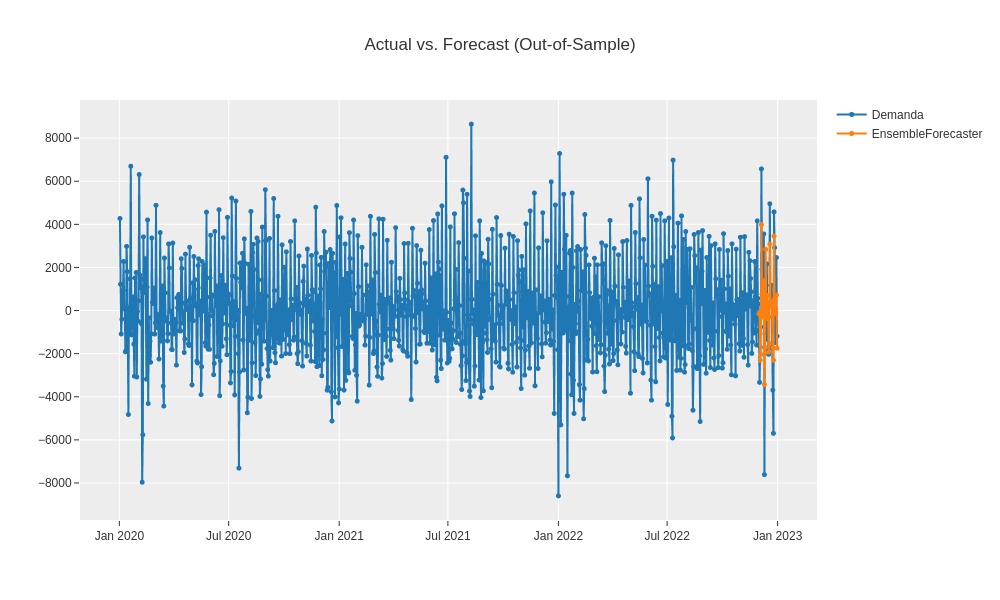

In [24]:
# Predicted vs Reality
exp.plot_model(estimator=blender, fig_kwargs=fig_kwargs)

* Analizamos graficamente la efectividad de la prediccion en los datos de Test (Dicimebre 2022)
* Esto lo seteamos en el parametro fh cuando creamos el Setup del modelo en las primeras lineas

In [25]:
# # NO FUNCIONA
# # Finalizamos el modelo, entrenando con todos los datos
# final_model = exp.finalize_model(blender)
# print(exp.predict_model(final_model))

# # Forexast para los datos del futuro
# exp.plot_model(final_model)


* Finalizamos el modelo entrenandolo con todos los datos disponibles (Train + Test)
* Predecimos los valores futuros todavia desconocidos (Enero 2023) y los visualizamos
* Guardamos el modelo por si lo queremos usar en el futuro, sin tener que volver a crearlo desde cero

## Analisis de Residuos

In [26]:
# Libreria importada del TP#1 para el analisis de residuos

# Instalacion y carga
# !pip install pingouin
import pingouin as pg
import statsmodels.api as sm
from scipy.stats import jarque_bera
from scipy.stats import shapiro
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_breuschpagan
from pmdarima.arima.utils import ndiffs

# Diferentes Tests de Normalidad
def residuos_normality(residuos):
  # Test Grafico
  pg.qqplot(residuos, dist='norm')
  plt.title('Normalidad de los Residuos')
  plt.show()

  # Test Analitico
  jarquebera = jarque_bera(residuos)[1]
  shapir = shapiro(residuos)[1]
  print('Shapiro p-value:', np.round(shapir, 3))
  print('Jarque-Bera p-value:', np.round(jarquebera, 3), '\n')

# Diferentes Tests de Autocorrelacion
def residuos_autocorrelation(residuos):
  # Test Grafico
  plot_acf(residuos, lags=len(residuos)-1)
  plt.title('Autocorrelacion de los Residuos')
  plt.show()
  # Tests Analiticos
  dw = sm.stats.stattools.durbin_watson(residuos)
  lb = sm.stats.acorr_ljungbox(residuos, lags=len(residuos)-1, return_df=True)
  print('Durbin-Watson (~2 = No-Autocorrelation):', np.round(dw, 3))
#   print('Ljung-Box p-value:', lb.lb_pvalue.values[3])

# Test Grafico de Homocedasticidad, el Analitco no lo pude hacer funcionar
def residuos_homocedasticity(residuos):
  # Grafico
  plt.scatter(range(len(residuos)), residuos)
  plt.axhline(y=0, color='r', linestyle='--')
  plt.xlabel('Tiempo')
  plt.ylabel('Residuos')
  plt.title('Homocedasticidad - Residuos a lo Largo del Tiempo')
  plt.show()

  # Analitico
  X = np.arange(len(residuos))
  X_with_const = sm.add_constant(X)
  print('Breusch-Pagan p-value (H0: Homocedasticity):', het_breuschpagan(residuos, X_with_const)[1].round(3))

# Llama a todos los test anteriores, mas la media
def residuos_evaluation(residuos):
  print('Media de los Residuos', np.round(residuos.mean(), 3))
  residuos_normality(residuos)
  residuos_autocorrelation(residuos)
  residuos_homocedasticity(residuos)


# Para obtener el d optimo a diferenciar
def diferenciacion(y):
  # Estimado de número de diferencias con ADF test:Dickey-Fuller
  n_adf = ndiffs(y, test='adf')  # -> 0

  # KPSS test (auto_arima default): Kwiatkowski-Phillips-Schmidt-Shin
  n_kpss = ndiffs(y, test='kpss')  # -> 0

  # PP test: Phillips-Perron
  n_pp = ndiffs(y, test='pp')  # -> 0

  print('Estimado de número de diferencias con KPSS test')
  print(n_kpss)
  print('Estimado de número de diferencias con ADF test')
  print(n_adf)
  print('Estimado de número de diferencias con PP test')
  print(n_pp)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,EnsembleForecaster,1.0049,0.8893,1439.4356,1743.9295,0.8935,0.9792,0.6517


Media de los Residuos 60.64


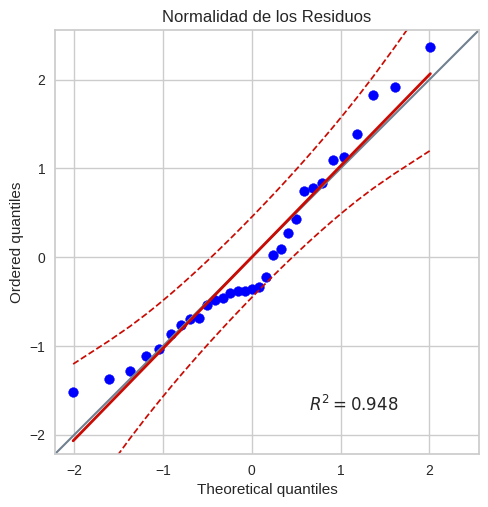

Shapiro p-value: 0.089
Jarque-Bera p-value: 0.293 



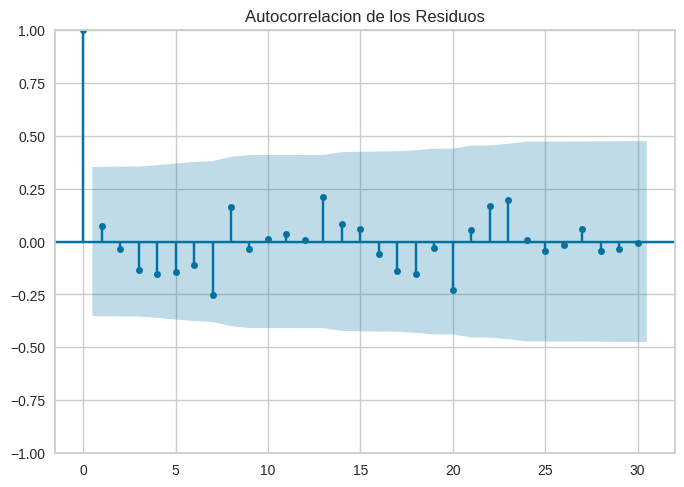

Durbin-Watson (~2 = No-Autocorrelation): 1.842


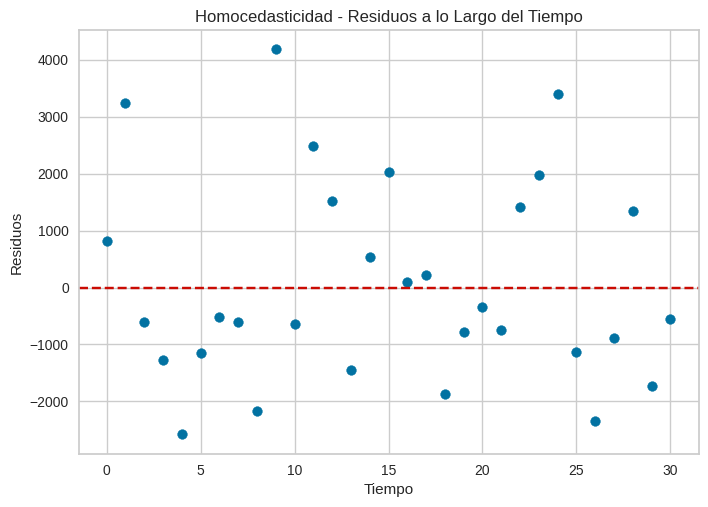

Breusch-Pagan p-value (H0: Homocedasticity): 0.501


In [27]:
# PyCaret no trae los residuos del modelo, los calculo a mano
residuos_blender = exp.predict_model(blender)['y_pred'] - exp.get_config('y_test')

# # Llamo a la funcion creada del TP#1
residuos_evaluation((residuos_blender))

# Nombres de todos los modelos
# best_baseline_models, best_tuned_models, blender, final_model

* Utilizamos una Funcion creada en el TP#1 extendida para analizar los Residuos del Modelo Auto-Blend creado, y vemos:
* Tanto los tests de Shapiro como de Jarque Bera nos indican que los residuos siguen una Distribucion Normal, lo que es bueno
* El test de Breusche-Pagan nos confirma la Homocedasiticdad de los residuos, lo que tambien es bueno. Lo verificamos graficamente
* Tambien confirmamos mediante el test de Durbin-Watson y en la grafica de PACF, que los residuos no estan correlacionados
* Por todo lo anterior podemos decir que la combinacion de modelos tuneados, **con los datos previamente diferenciados**, es mas que aceptable
* En otra notebook probamos el mismo Pipeline pero con los datos sin diferenciar, y el analisis de diagnostico no fue tan bueno, ya que se observo bastante autocorrelacion en los resiudos. Ademas la libreria selecciono otros modelos como optimos, aunque coincidio en que Prophet es el que mejor performa

In [28]:
# Chequeo sobre Diferenciacion en la Serie Original de Demanda

print('Para Demanda:')
print(diferenciacion(data['Demanda']), '\n')
print('Para Viento:')
print(diferenciacion(data['Viento']))

Para Demanda:
Estimado de número de diferencias con KPSS test
0
Estimado de número de diferencias con ADF test
0
Estimado de número de diferencias con PP test
0
None 

Para Viento:
Estimado de número de diferencias con KPSS test
0
Estimado de número de diferencias con ADF test
0
Estimado de número de diferencias con PP test
0
None


* Como dijimos previamente, las series ya estan diferenciadas, no es necesario diferenciarlas nuevamente